In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt






In [2]:
#Create a pandas DataFrame for the counts data set.
df = pd.read_csv('nyc_bb_bicyclist_counts.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
df.head(5)


,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807


In [3]:
#solit data into month, day of the week and day variables.
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['DAY'] = ds.dt.day
df[70:80]

,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-06-10,84.0,68.0,0.00,3066,6,5,10
2017-06-11,90.0,73.0,0.00,2465,6,6,11
2017-06-12,91.9,77.0,0.00,2854,6,0,12
2017-06-13,93.9,78.1,0.01,2882,6,1,13
2017-06-14,84.0,69.1,0.29,2596,6,2,14
2017-06-15,75.0,66.0,0.00,3510,6,3,15
2017-06-16,68.0,66.0,0.00,2054,6,4,16
2017-06-17,73.0,66.9,1.39,1399,6,5,17
2017-06-18,84.0,72.0,0.01,2199,6,6,18


In [4]:

#Create the training and testing data sets.
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=178
Testing data set length=36


In [5]:

#Setup the regression expression in patsy notation. BB_COUNT is our dependent variable and
# it depends on the regression variables: DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP.
expr = """BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP"""

#Set up the X and y matrices (endogenouts and exogeneous)

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

#Using the statsmodels GLM class, we first train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#Print the summary.
print(poisson_training_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  178
Model:                            GLM   Df Residuals:                      171
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13181.
Date:                Sun, 18 Feb 2024   Deviance:                       24644.
Time:                        22:07:22   Pearson chi2:                 2.46e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.0891      0.013    558.900      

In [6]:
X_train.head(5)

,Intercept,DAY,DAY_OF_WEEK,MONTH,HIGH_T,LOW_T,PRECIP
Date,,,,,,,
2017-04-01,1.0,1.0,5.0,4.0,46.0,37.0,0.00
2017-04-02,1.0,2.0,6.0,4.0,62.1,41.0,0.00
2017-04-03,1.0,3.0,0.0,4.0,63.0,50.0,0.03
2017-04-05,1.0,5.0,2.0,4.0,63.0,46.0,0.00
2017-04-06,1.0,6.0,3.0,4.0,48.9,41.0,0.73


In [7]:


#Make some predictions on the test data set.
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)



                   mean    mean_se  mean_ci_lower  mean_ci_upper
Date                                                            
2017-04-04   771.882203   7.190798     757.916385     786.105363
2017-04-07  1908.356616  10.244651    1888.382733    1928.541769
2017-04-08  2320.486512  10.750464    2299.511364    2341.652986
2017-04-19  2150.750953   9.816586    2131.596602    2170.077425
2017-04-27  2548.883427   9.350400    2530.622707    2567.275915
2017-05-04  2508.113387   8.654692    2491.207734    2525.133763
2017-05-08  2511.914149  10.844262    2490.749454    2533.258687
2017-05-15  2744.125892   9.101181    2726.345756    2762.021982
2017-05-16  3336.963617  11.255547    3314.975910    3359.097164
2017-05-27  2576.201085   8.750782    2559.106834    2593.409521
2017-05-29  2063.170646  10.706415    2042.292810    2084.261910
2017-06-02  2742.433061   8.208737    2726.391333    2758.569176
2017-06-04  2169.167681   8.629215    2152.320494    2186.146739
2017-06-09  3230.707338  

predicted counts versus the actual counts for the test data.

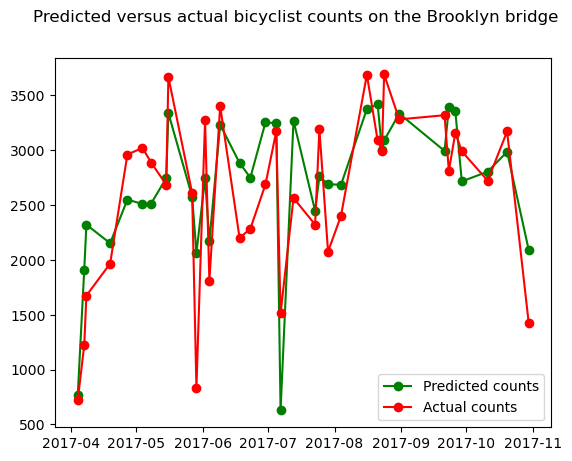

In [8]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
#Mlot the predicted counts versus the actual counts for the test data.
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()



We can have scatter plot of Actual versus Predicted counts. This is based on scale of actual and predicted counts 

<Figure size 640x480 with 0 Axes>

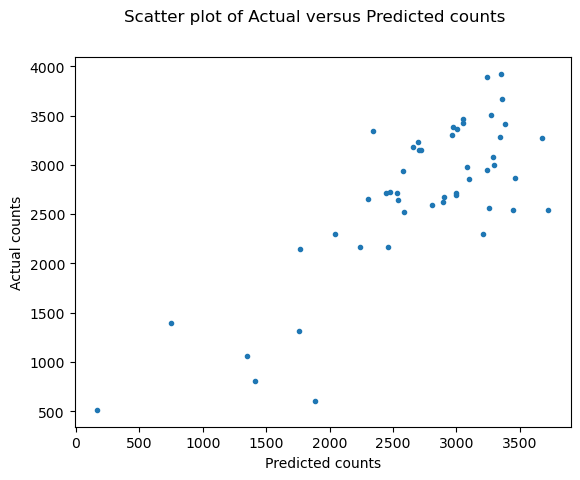

In [9]:

plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

In [23]:
NBD_training_results = sm.NegativeBinomial(endog=y_train, exog=X_train).fit()

         Current function value: 7.904086
         Iterations: 22
         Function evaluations: 119
         Gradient evaluations: 107


C:\Users\rtelang\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
NBD_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:               BB_COUNT   No. Observations:                  171
Model:               NegativeBinomial   Df Residuals:                      164
Method:                           MLE   Df Model:                            6
Date:                Tue, 26 Sep 2023   Pseudo R-squ.:                 0.05390
Time:                        21:25:17   Log-Likelihood:                -1351.6
converged:                      False   LL-Null:                       -1428.6
Covariance Type:            nonrobust   LLR p-value:                 1.101e-30
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.7719      0.171     39.535      0.000       6.436       7.108
DAY             0.0009      0.002      0.388      0.698      -0.004       0.005
DAY_OF_WEEK    -0.0273      0.010     -2.637      0.008      -0.048      -0.007
MONTH           0.0138      0.010      1.340      0.180      -0.006       0.034
HIGH_T          0.0329      0.005      6.975      0.000       0.024       0.042
LOW_T          -0.0212      0.005     -4.196      0.000      -0.031      -0.011
PRECIP         -0.6063      0.049    -12.310      0.000      -0.703      -0.510
alpha           0.0682      0.007      9.222      0.000       0.054       0.083
===============================================================================
"""

In [24]:

#Make some predictions on the test data set.
NBD_predictions = NBD_training_results.predict(X_test)
#.summary_frame() returns a pandas DataFrame
#predictions_summary_frame = NBD_predictions.summary_frame()
print(NBD_predictions)


Date
2017-04-02    2532.636552
2017-04-09    2656.259826
2017-04-13    2475.731380
2017-04-16    3461.269698
2017-04-17    2698.558380
2017-04-24    2272.390083
2017-04-28    3672.694573
2017-05-11    2170.241601
2017-05-18    3679.255531
2017-05-20    2111.186124
2017-05-24    2348.771312
2017-05-25    1231.199685
2017-05-27    2409.490456
2017-05-30    1895.736015
2017-06-01    3071.229281
2017-06-04    2075.345871
2017-06-17     890.152529
2017-06-20    2957.263825
2017-06-22    3006.768072
2017-07-05    3318.481714
2017-07-07     824.289740
2017-07-12    3197.022985
2017-07-19    3597.609830
2017-07-21    3458.926176
2017-07-22    2244.134841
2017-07-23    2315.758858
2017-07-31    4080.345944
2017-08-08    2943.730642
2017-08-12    2487.106488
2017-08-14    3073.299828
2017-08-20    2806.918043
2017-08-21    3371.229938
2017-08-24    3006.350916
2017-08-27    2812.162888
2017-08-30    3026.533507
2017-09-07    2686.206065
2017-09-11    3559.832882
2017-09-12    3357.276498
2017-09

(array([2., 0., 1., 0., 0., 1., 0., 0., 2., 0., 2., 1., 0., 1., 0., 2., 1.,
        0., 2., 2., 0., 2., 2., 1., 4., 0., 1., 0., 0., 4., 3., 3., 2., 2.,
        0., 0., 0., 1., 0., 1.]),
 array([ 461.   ,  553.125,  645.25 ,  737.375,  829.5  ,  921.625,
        1013.75 , 1105.875, 1198.   , 1290.125, 1382.25 , 1474.375,
        1566.5  , 1658.625, 1750.75 , 1842.875, 1935.   , 2027.125,
        2119.25 , 2211.375, 2303.5  , 2395.625, 2487.75 , 2579.875,
        2672.   , 2764.125, 2856.25 , 2948.375, 3040.5  , 3132.625,
        3224.75 , 3316.875, 3409.   , 3501.125, 3593.25 , 3685.375,
        3777.5  , 3869.625, 3961.75 , 4053.875, 4146.   ]),
 <BarContainer object of 40 artists>)

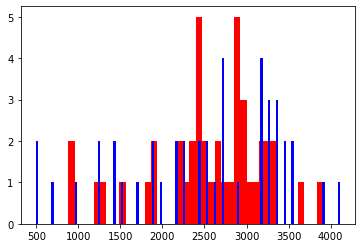

In [12]:
plt.hist(NBD_predictions,40,color='red')
plt.hist(actual_counts, 40,color='blue',rwidth=0.3)

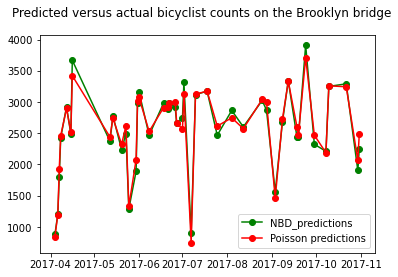

In [13]:
#predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['BB_COUNT']
#Mlot the predicted counts versus the actual counts for the test data.
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, NBD_predictions, 'go-', label='NBD_predictions')
actual, = plt.plot(X_test.index, predicted_counts, 'ro-', label='Poisson predictions')
plt.legend(handles=[predicted, actual])
plt.show()